In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
from _info_ import ear_types, degrees, acupoints_name, cm
from _common_ import angles
from typing import Union

In [2]:
class errors():
    def __init__(self, path_folder):
        self.path_folder = path_folder
        self.warp_result = None
        
    def read_error_csv(self, fpath1):
        error_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return error_np

    def wrap_err_from_csv(self):
        result = {}
        for ear_type in ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.path_folder, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in degrees:
                    angles_err = []
                    
                    csv_pth = os.path.join("..", self.path_folder, ear_type, "result", name, "error", deg, "error.csv")
                    error_np = self.read_error_csv(csv_pth)
                    indexes = angles(error_np, 4)
                    
                    for index in indexes:
                        angles_err.append(error_np[index])
                    deg_err.append(angles_err)
                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
        return result     

In [29]:
class plot_fig():
    def __init__(self, errors: Union[dict, list]):
        self.wrapped_errors = errors
#         print(np.array(errors[0]["free"]).shape)
        
    def unwrapped_to_CDF(self, wrapped_errors_dict):
        CDF = {}
        for ear_type in ear_types:
            CDF[ear_type]= {}
            total = np.array(wrapped_errors_dict[ear_type])
            total = total.reshape(-1)
            
            sorted_error = np.sort(total*10)
            cumulative_prob = np.arange(1, len(total) + 1) / len(total)
            
            CDF[ear_type]["sorted_error"] = sorted_error
            CDF[ear_type]["cumulative_prob"] = cumulative_prob
            
        return CDF
    def CDF_fig(self, title, label):
        if isinstance(self.wrapped_errors, dict):
            CDF = self.unwrapped_to_CDF(self.wrapped_errors)
            for ear_type in ear_types: 

                plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label)
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()
        elif isinstance(self.wrapped_errors, list):
            for ear_type in ear_types:
                for i in range(0, len(self.wrapped_errors)):
                    CDF = self.unwrapped_to_CDF(self.wrapped_errors[i])
                    plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label[i])
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()

        else:
            raise ValueError("Unsupported type")
    def bar_fig(self, label, plot_type = "acupoints"):
        
        if isinstance(self.wrapped_errors, dict):
            if plot_type == "acupoints":
                permute_dim = (1, 2, 3, 0)
                title = "Acupoint localization error"
            else:
                permute_dim = (1, 2, 0, 3)
                title = "Acupoint localization error on different subjects"
            for ear_type in ear_types:
                x = np.transpose(self.wrapped_errors[ear_type], permute_dim)*10
                means = np.nanmean(x, axis = 3)
                stds = np.nanstd(x, axis = 3)
                if plot_type == "acupoints":
                    tick_label = acupoints_name[:x.shape[2]]
                else:
                    tick_label = ["Subject"+str(x) for x in list(range(0 , x.shape[2]))]
                
                for i in range(0, len(x)):
                    plt.figure(figsize=(15,10))
                    for j in range(0 ,len(x[0])):

                        plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)

                    plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                    font_path = r'C:\Windows\Fonts\msjhl.ttc'
                    font = FontProperties(fname=font_path, size=12)
                    
                    plt.xticks(np.arange(x.shape[2]) + 0.3, tick_label, fontsize=12, rotation=-45, ha='center')
         
                    plt.yticks(fontsize=30)
                    plt.title(title, fontsize = 30, pad = 20)

                    plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

                    plt.tight_layout()

                    if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
                        os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
                    plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

                    plt.show()
        else:
            raise ValueError("Unsupported type")
    def bar_fig_total(self, title, label):
        if isinstance(self.wrapped_errors, list):
            plt.figure(figsize=(15,10))
            for i in range(0, len(self.wrapped_errors)): 
                
                means = []
                stds = []
                for ear_type in ear_types:
                    means.append(np.nanmean(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                    stds.append(np.nanstd(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                plt.bar(np.arange(len(ear_types)) + i*0.2, means, yerr=stds, align='center', label = label[i], ecolor='black', capsize=3, width=0.2)
            plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

            plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

            font_path = r'C:\Windows\Fonts\msjhl.ttc'
            font = FontProperties(fname=font_path, size=12)

            plt.xticks(np.arange(len(ear_types)) + 0.1, ear_types, fontsize=20, rotation=0, ha='center')

            plt.yticks(fontsize=30)
            plt.title(title, fontsize = 30, pad = 20)

            plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

            plt.tight_layout()
    #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
    #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
    #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

            plt.show()
        else:
            raise ValueError("Unsupported type")

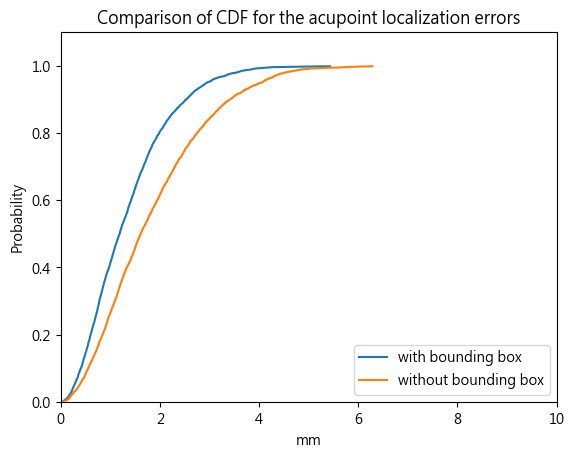

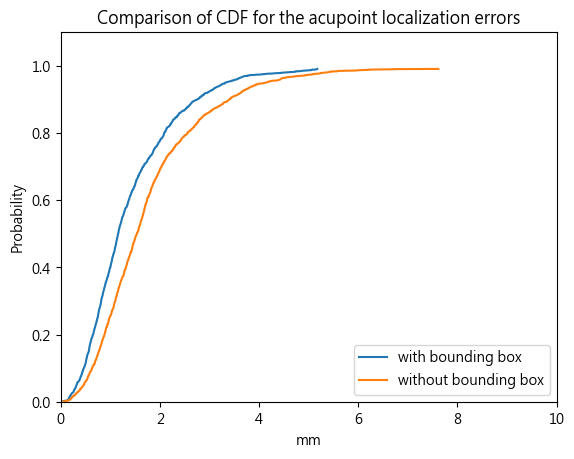

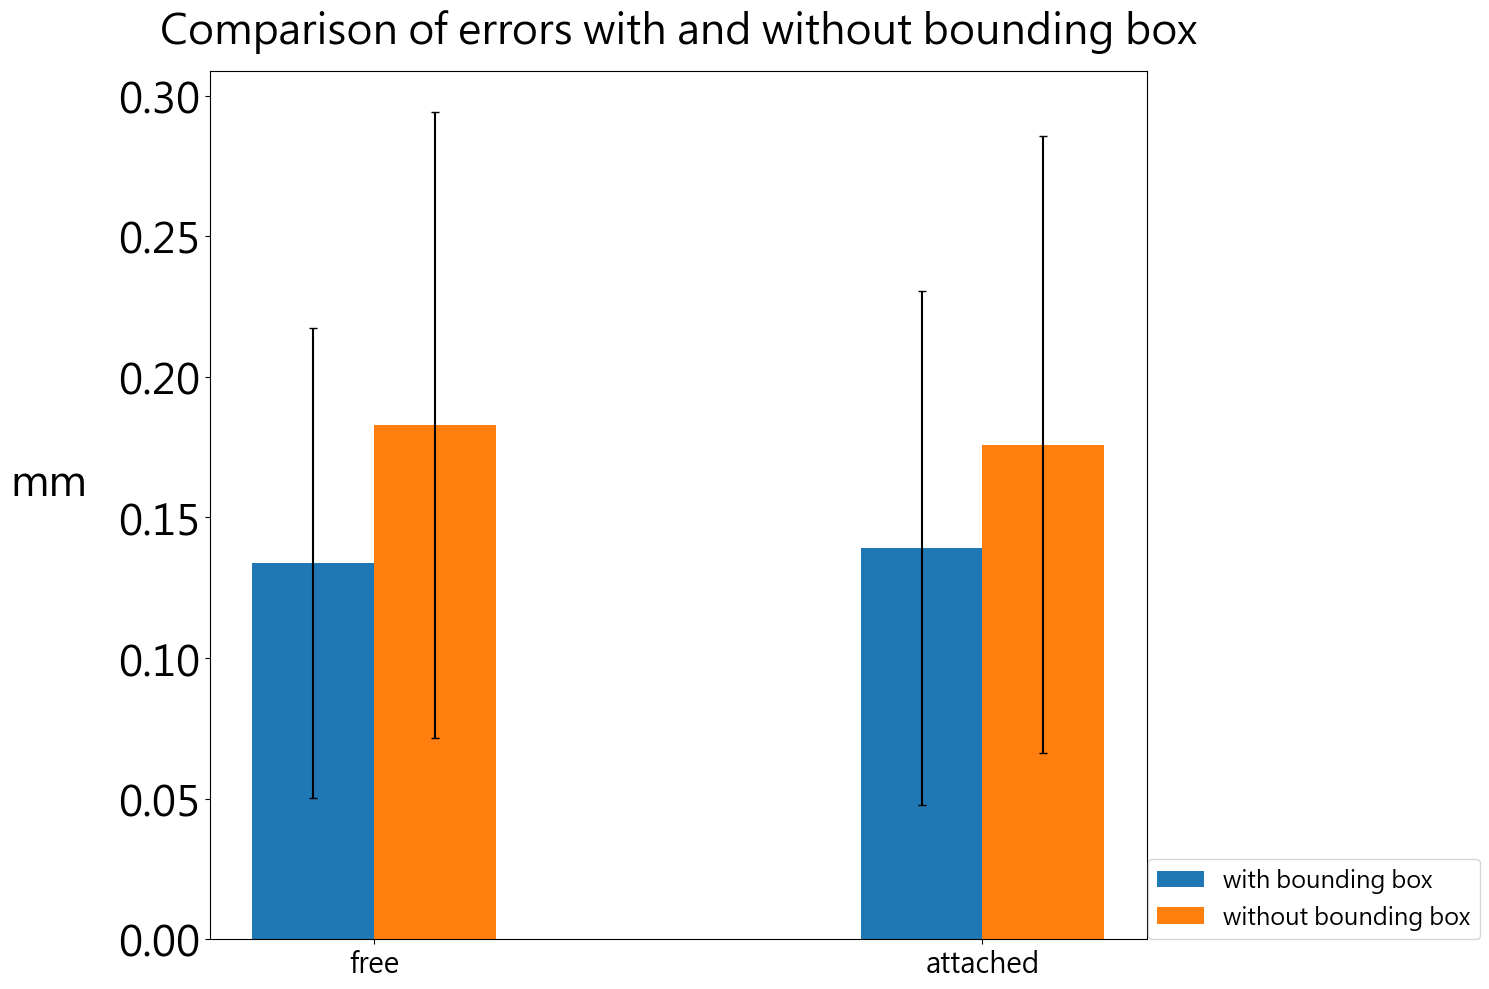

In [30]:
if __name__ == '__main__':
    A = errors("MAT_inpainting")
    B = errors("without_bbox")
    wrapped_errors_A = A.wrap_err_from_csv()
    wrapped_errors_B = B.wrap_err_from_csv()
    C = plot_fig([wrapped_errors_A, wrapped_errors_B])
#     D = plot_fig(wrapped_errors_B)

    C.CDF_fig("Comparison of CDF for the acupoint localization errors", ["with bounding box", "without bounding box"])
    C.bar_fig_total("Comparison of errors with and without bounding box", ["with bounding box", "without bounding box"])

In [ ]:
class localization_error_Draw():
    def __init__(self, le_0):
        self.le_0 = le_0
    def read_csv_to_np(self, fpath1):
        df_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return df_np
    def all_err(self):
        result = {}
        for ear_type in self.le_0.ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.le_0.src, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in self.le_0.degrees:
                    angles_err = []
                    error_np = self.read_csv_to_np(os.path.join("..", self.le_0.src, ear_type, "result", name, "error", deg, "error.csv"))
                    interval = len(error_np) / 3
                    index = [0, int(interval), int(interval*2), len(error_np)-1]
                    for i in index:
                        angles_err.append(error_np[i])

                    deg_err.append(angles_err)

                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
            result[ear_type] = np.array(result[ear_type])
#             print(np.nanmean(result[ear_type], axis = (2,3)))
            
            
        return result
    
    def draw_each_acu_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 3, 0))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, self.le_0.acupoints_name[:x.shape[2]], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()

    
        
        
        
    def draw_each_subject_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 0, 3))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, ["Subject"+str(x) for x in list(range(0 , x.shape[2]))], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()
        
    def draw_total_bars(self, title, all_errs, different_methods):
        plt.figure(figsize=(15,10))
        for i in range(0, len(all_errs)):
            means = []
            stds = []
            for ear_type in self.le_0.ear_types:
                means.append(np.nanmean(all_errs[i][ear_type], axis = (0,1,2,3))*10)
                stds.append(np.nanstd(all_errs[i][ear_type], axis = (0,1,2,3))*10)

                print(ear_type,means)

            plt.bar(np.arange(len(self.le_0.ear_types)) + i*0.2, means, yerr=stds, align='center', label = different_methods[i], ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.le_0.ear_types)) + 0.1, self.le_0.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

        plt.legend(fontsize=17, ncol = 2)

        plt.tight_layout()

        if not os.path.isdir(os.path.join("..", "figure", "diff_inpainting_way")):
            os.makedirs(os.path.join("..", "figure", "diff_inpainting_way"))
        plt.savefig(os.path.join("..", "figure", "diff_inpainting_way",'total_average.png').format(index = 0))

        plt.show()

